# Feature Engineering et Analyse exploratoire croisée des données

## Principale tâche à résoudre 

Identifier les 5% utilisateurs les plus actifs pour les classer en tant que **super-utilisateurs** (pour bénéficier d'avantages sur le site)

Pour quantifier l'activité d'un utilisateur, on se base sur :

- **son ajout de recettes** (avec coefficient mélioratif en fonction de la note générale utilisateur) potentiellement sur les 3 dernières années
- **les notations seules ou les reviews seules laissées** (si l'utilisateur a laissé soit une note soit un reviewing) potentiellement sur les 3 dernières années
- **les notations + reviews laissées** (si l'utilisateur a laissé à la fois une note et un reviewing = bonus) potentiellement sur les 3 dernières années
- **la récence de ses différentes contributions** (ajout d'un coefficient qui traduit si l'utilisateur a fait un ajout récent ou non)

## Temps d'exécution d'environ 4 minutes

#### _Première approche : 1ère distribution de super-utilisateurs_

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta

start_time = time.time()

In [2]:
# Extraction des dataframes utilisées
interactions = pd.read_csv('recipe/RAW_interactions.csv')
recipes = pd.read_csv('recipe/RAW_recipes.csv')

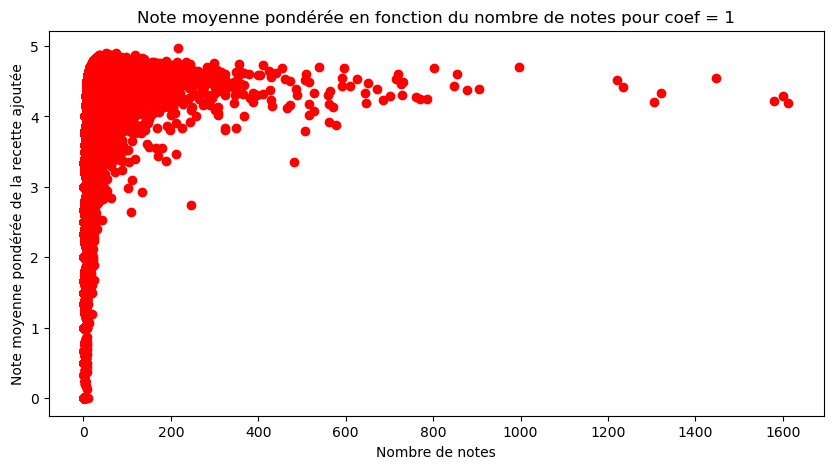

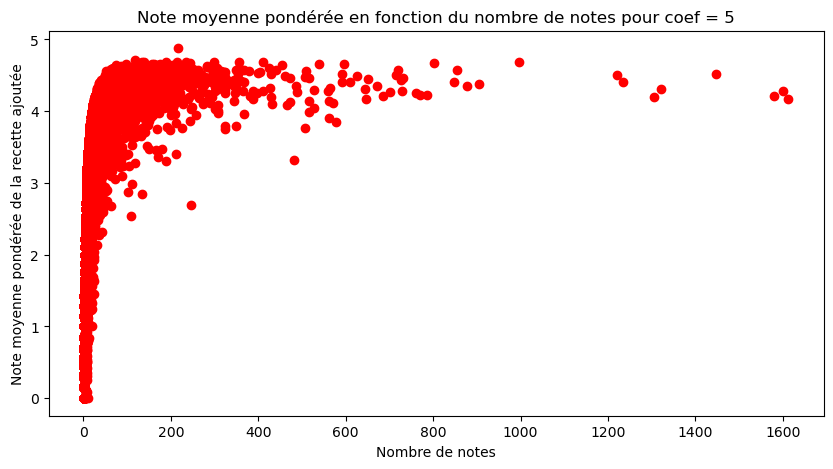

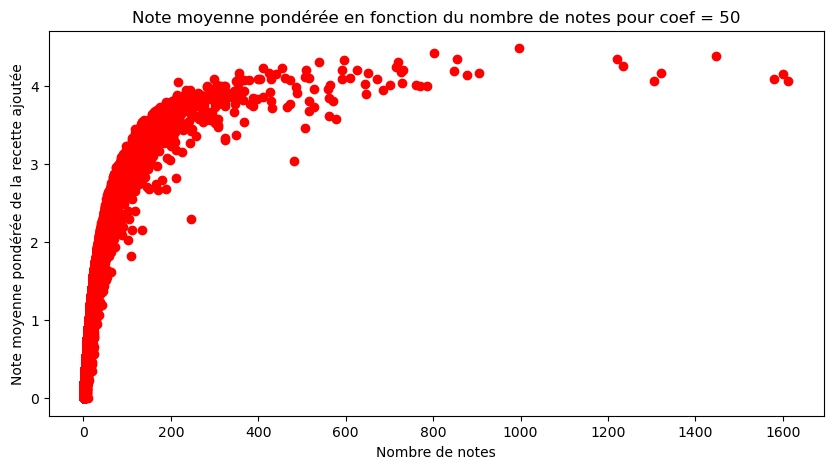

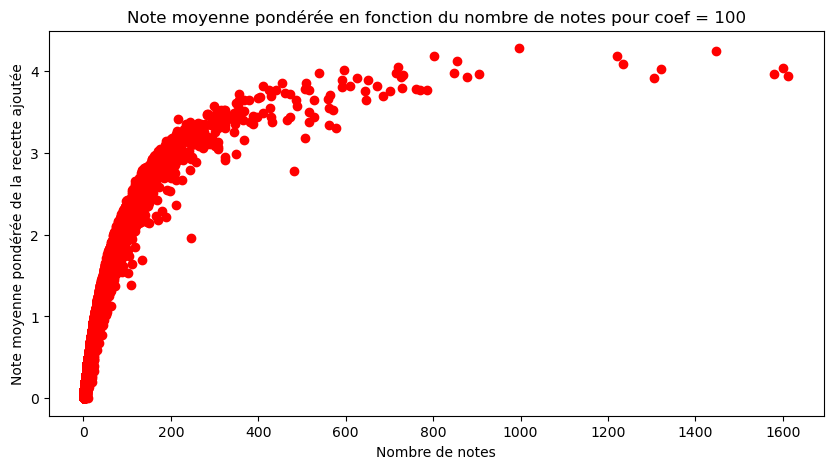

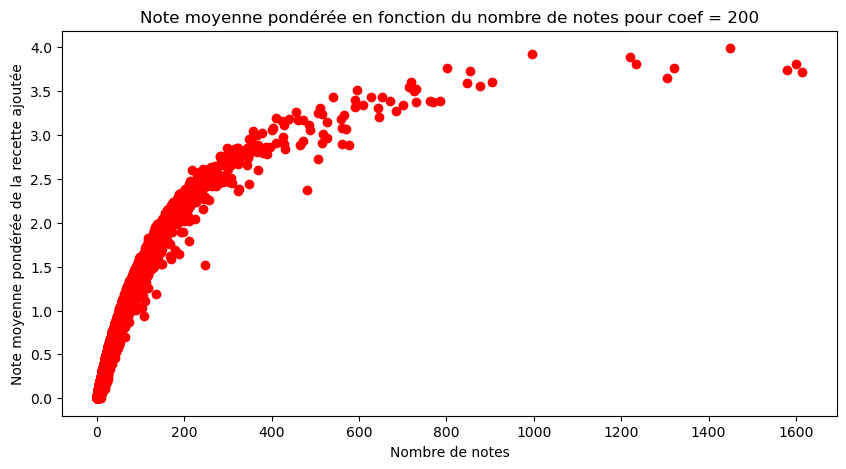

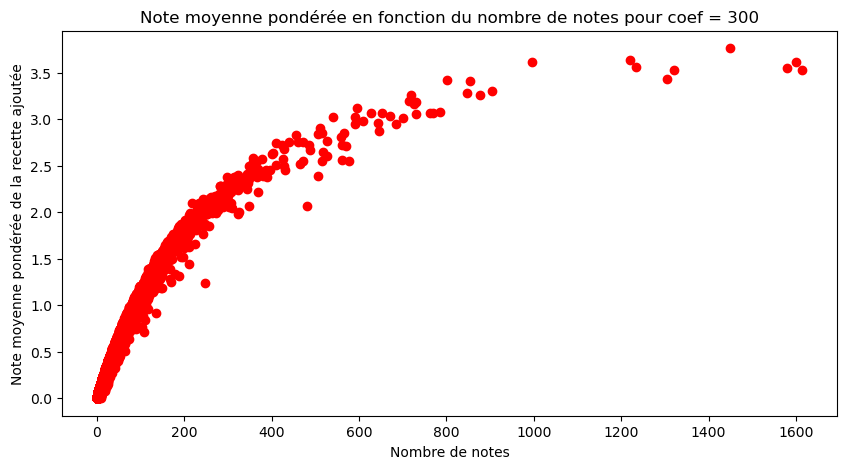

In [3]:
# Creation d'un dataframe recipe_rating qui associe les recettes et les notes moyennes qu'elles ont recu par les utilisateurs
# On pondère les notes en fonction du nombre de notes qu'elles ont recu en fonction d'un coefficient à déterminer

coef_list = [1, 5, 50, 100, 200, 300]

for coef in coef_list:
    recipe_rating= pd.DataFrame(interactions.groupby('recipe_id')['rating'].sum()/(interactions.groupby('recipe_id')['rating'].count()+coef))
    recipe_rating['rating_count'] = interactions.groupby('recipe_id')['rating'].count()
    recipe_rating['recipe_id'] = recipe_rating.index
    recipe_rating = recipe_rating.reset_index(drop=True)
    
    fig = plt.figure(figsize=(10,5))
    plt.plot(recipe_rating['rating_count'], recipe_rating['rating'], 'ro')
    plt.xlabel('Nombre de notes')
    plt.ylabel('Note moyenne pondérée de la recette ajoutée')
    plt.title('Note moyenne pondérée en fonction du nombre de notes pour coef = ' + str(coef))

Selon mes observations, des coefficients entre 100 et 200 sont des coefficients qui pondèrent plutôt bien la moyenne en fonction du nombre de notes. Au delà, la moyenne globale des notes baisse beaucoup trop.
Je choisit d'utiliser coef = 150 

In [4]:
# On crée un dataframe recipe_rating qui associe les recettes et les notes moyennes qu'elles ont recu par les utilisateurs 
# (on affiche l'id de la recette, la note moyenne pondérée, le nombre de notes et la note moyenne)
recipe_rating= pd.DataFrame(interactions.groupby('recipe_id')['rating'].sum()/(interactions.groupby('recipe_id')['rating'].count()+150)) 
recipe_rating['mean_rating'] = interactions.groupby('recipe_id')['rating'].mean()
recipe_rating['rating_count'] = interactions.groupby('recipe_id')['rating'].count()
recipe_rating['recipe_id'] = recipe_rating.index
recipe_rating = recipe_rating.reset_index(drop=True)
recipe_rating = recipe_rating[['recipe_id', 'rating', 'rating_count', 'mean_rating']]
recipe_rating = recipe_rating.sort_values('rating_count', ascending=False)
recipe_rating = recipe_rating.rename(columns={'rating': 'weighted_recipe_rating'})
print(recipe_rating.head(1))

     recipe_id  weighted_recipe_rating  rating_count  mean_rating
833       2886                3.829836          1613     4.185989


In [5]:
# Création d'un dataframe added_recipes qui contient les recettes ajoutées par les utilisateurs
added_recipes = pd.DataFrame(columns = ['user_id', 'recipe_id', 'user_rating1'])

In [6]:
# Faire une jointure d'addeed_recipes et de recipes au niveau de user_id, recipe_id
added_recipes['user_id'] = recipes['contributor_id']
added_recipes['recipe_id'] = recipes['id']

# Pour les recettes qui ont une note moyenne, on les ajoute dans le dataframe added_recipes (avec jointure)
added_recipes = added_recipes.merge(recipe_rating, on='recipe_id', how='left')
added_recipes = added_recipes[['user_id', 'recipe_id', 'user_rating1', 'weighted_recipe_rating', 'rating_count']]

# Pour les recettes qui n'ont pas de note moyenne, on les ajoute dans le dataframe added_recipes avec une note de 1 (A REDIMENSIONNER)
added_recipes['weighted_recipe_rating'] = added_recipes['weighted_recipe_rating'].fillna(1)

In [7]:
# Calculer le score de chaque user en fonction de la note pondérée de chaque recette qu'il a ajouté
added_recipes['user_rating1'] = added_recipes['weighted_recipe_rating'] * 10
print(added_recipes.sort_values('rating_count', ascending=False).head(2))

        user_id  recipe_id  user_rating1  weighted_recipe_rating  rating_count
22168      1762       2886     38.298355                3.829836          1613
213826    28201      27208     39.211879                3.921188          1601


In [8]:
# Grouper par user_id et calculer la somme de user_rating et le nombre de recettes ajoutées pour chaque utilisateur
added_recipes = added_recipes.groupby(['user_id']).agg({'user_rating1': 'sum', 'recipe_id': 'count'}).reset_index()

# Trier par recipe_id décroissant (le plus de recettes ajoutées)
added_recipes = added_recipes.sort_values('recipe_id', ascending=False)
added_recipes = added_recipes.rename(columns={'recipe_id': 'nb_recipes_added'})
print(added_recipes.head(2))
print(added_recipes.shape)

      user_id  user_rating1  nb_recipes_added
4628    89831   6971.048743              3118
2103    37779   3105.914684              2553
(27926, 3)


Text(0.5, 1.0, 'Score des utilisateurs en fonction du nombre de recettes ajoutées')

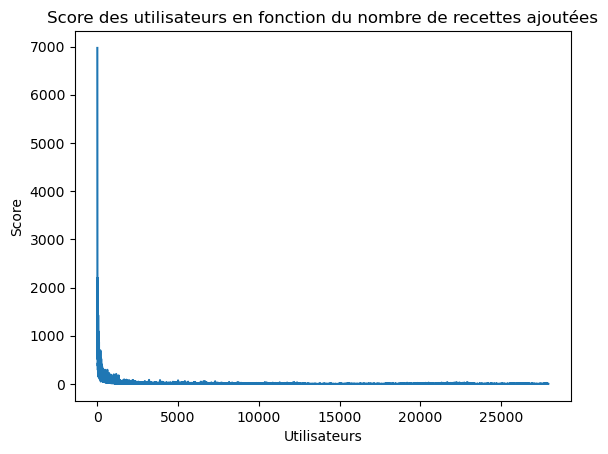

In [9]:
# On plot le score des utilisateurs en fonction du nombre de recettes ajoutées pour observer la tendance globale
plt.plot(added_recipes['user_rating1'].tolist())
plt.xlabel('Utilisateurs')
plt.ylabel('Score')
plt.title('Score des utilisateurs en fonction du nombre de recettes ajoutées')

Text(0.5, 1.0, 'Score des utilisateurs en fonction du nombre de recettes ajoutées')

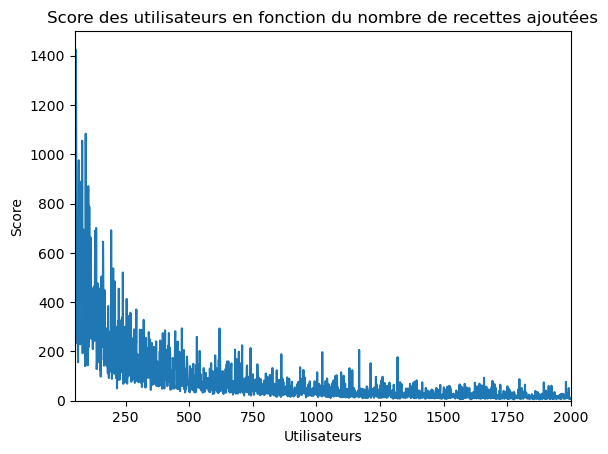

In [10]:
# Même chose sauf que l'on exclut les utilisateurs qui ont obtenu un score trop élevé
plt.plot(added_recipes['user_rating1'].tolist())
plt.xlabel('Utilisateurs')
plt.xlim(50, 2000)
plt.ylim(0, 1500)
plt.ylabel('Score')
plt.title('Score des utilisateurs en fonction du nombre de recettes ajoutées')

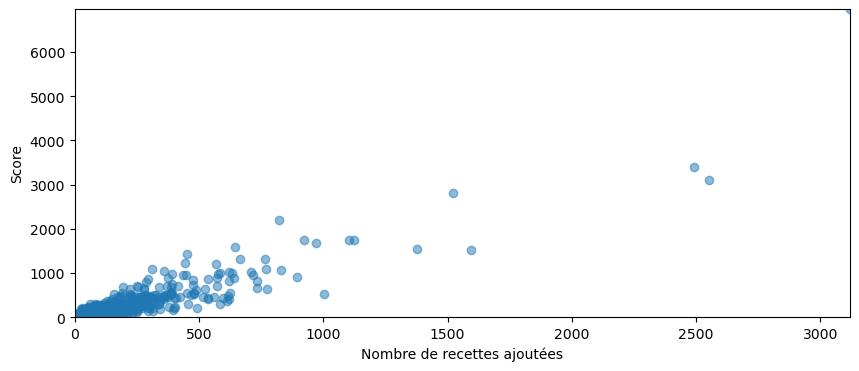

In [11]:
# Plot le score des utilisateurs en fonction du nombre de recettes ajoutées
plt.figure(figsize=(10,4))
plt.xlim(0, added_recipes['nb_recipes_added'].max())
plt.ylim(0, added_recipes['user_rating1'].max())
plt.xlabel('Nombre de recettes ajoutées')
plt.ylabel('Score')
plt.scatter(added_recipes['nb_recipes_added'], added_recipes['user_rating1'], alpha=0.5)
plt.show()

Logiquement, plus il y a eu de notes ajoutées, plus le score est élevé. Il sera intéressant de refaire ce graphe après avoir pris en compte la temporalité des actions de l'utilisateur afin d'observer si cette tendance évolue. On pourrait s'attendre par exemple à peut-être avoir des scores très élevés pour des pour un nombre de recettes pas forcément important mais qui ont été ajoutées récemment.

In [12]:
# Création d'un dataframe addded_interactions avec comme colonne user_id recipe_id rating_only review_only rating_and_review
added_interactions = pd.DataFrame(columns = ['user_id', 'recipe_id', 'rating_only', 'review_only', 'rating_and_review', 'user_rating2'])

In [13]:
# Dans added_interactions, on ajoute les user_id et recipe_id du dataframe interactions et on ajoute 1 dans la colonne rating_only si rating est non null
# et pareil pour review_only et rating_and_review
added_interactions['user_id'] = interactions['user_id']
added_interactions['recipe_id'] = interactions['recipe_id']
added_interactions['rating_only'] = interactions['rating'].notnull().astype(int)
added_interactions['review_only'] = interactions['review'].notnull().astype(int)
added_interactions['rating_and_review'] = (interactions['rating'].notnull() & interactions['review'].notnull()).astype(int)

In [14]:
# Si rating_and_review = 1, on met 0 dans rating et review de added_interactions
added_interactions.loc[added_interactions['rating_and_review'] == 1, 'rating_only'] = 0
added_interactions.loc[added_interactions['rating_and_review'] == 1, 'review_only'] = 0

In [15]:
# On remarque que tous les utilisateurs ont au moins mis une note, mais pas toujours une review
# On va grouper added_interactions par user_id et calculer la somme de rating, review et rating_and_review
added_interactions = added_interactions.groupby(['user_id']).agg({'rating_only': 'sum', 'review_only': 'sum', 'rating_and_review': 'sum'}).reset_index()
print(added_interactions.shape)

(226570, 4)


In [16]:
# Trier par rating décroissant (le plus de notes ajoutées sans review)
added_interactions = added_interactions.sort_values('rating_and_review', ascending=False)
print(added_interactions.iloc[0:10])

       user_id  rating_only  review_only  rating_and_review
46329   424680            0            0               7671
3826     37449            0            0               5603
43248   383346            0            0               4628
20019   169430            0            0               4076
15168   128473            0            0               3917
10551    89831            0            0               3353
6942     58104            0            0               3288
15636   133174            0            0               3107
23735   199848            0            0               3018
35099   305531            0            0               2902


In [17]:
# Calculer le user_rating en faisant rating_only*3 + review_only*3 + rating_and_review*10
added_interactions['user_rating2'] = added_interactions['rating_only']*7.5 + added_interactions['review_only']*7.5 + added_interactions['rating_and_review']*15
print(added_interactions.head())

       user_id  rating_only  review_only  rating_and_review  user_rating2
46329   424680            0            0               7671      115065.0
3826     37449            0            0               5603       84045.0
43248   383346            0            0               4628       69420.0
20019   169430            0            0               4076       61140.0
15168   128473            0            0               3917       58755.0


In [18]:
# Créer rating_only en groupant par rating_only et en comptant le nombre de user_id (idem pour review_only et rating_and_review)
rating_only = added_interactions.groupby(['rating_only']).agg({'user_id': 'count'}).reset_index()
rating_only = rating_only.rename(columns={'user_id': 'nb_of_x_rating_only'})
review_only = added_interactions.groupby(['review_only']).agg({'user_id': 'count'}).reset_index()
review_only = review_only.rename(columns={'user_id': 'nb_of_x_review_only'})
rating_and_review = added_interactions.groupby(['rating_and_review']).agg({'user_id': 'count'}).reset_index()
rating_and_review = rating_and_review.rename(columns={'user_id': 'nb_of_x_rating_and_review'})
print(rating_only.head())
print(review_only.head())
print(rating_and_review.head())
print(f"Nb max de rating+review laissés par au moins 1 personne : {rating_and_review['rating_and_review'].max()}")

   rating_only  nb_of_x_rating_only
0            0               226403
1            1                  165
2            2                    2
   review_only  nb_of_x_review_only
0            0               226570
   rating_and_review  nb_of_x_rating_and_review
0                  0                        151
1                  1                     166111
2                  2                      22736
3                  3                       9344
4                  4                       5143
Nb max de rating+review laissés par au moins 1 personne : 7671


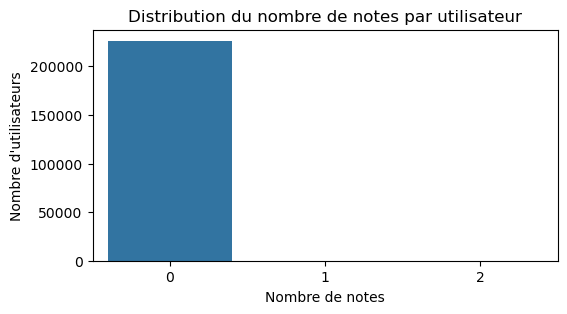

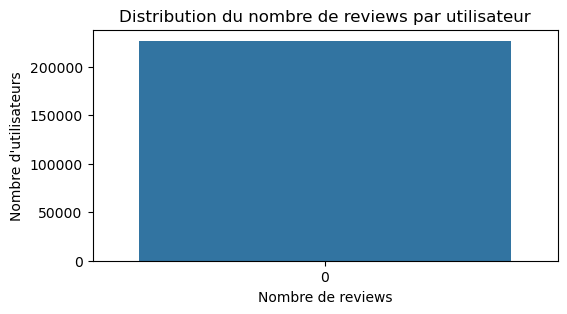

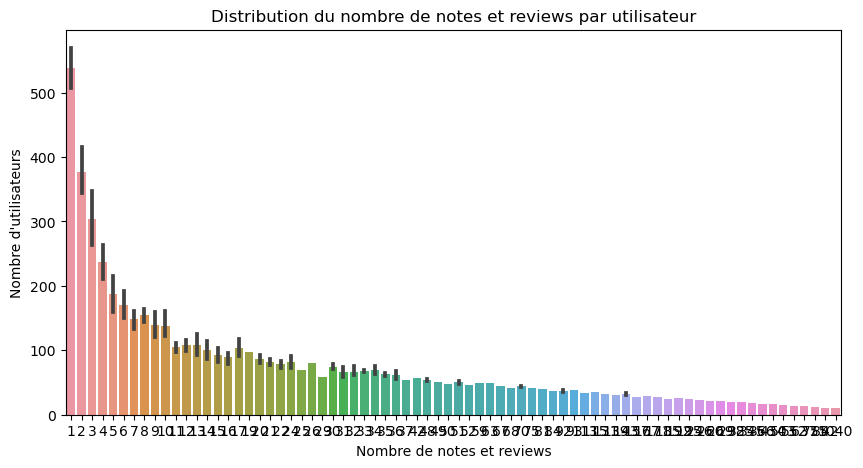

(531, 2)
rating_and_review            831
nb_of_x_rating_and_review      1
Name: 510, dtype: int64


In [19]:
# Distribution rating_only avec rating_only en abscisse et nb_of_x_rating_only en ordonnée
plt.figure(figsize=(6,3))
sns.barplot(x='rating_only', y='nb_of_x_rating_only', data=rating_only)
plt.xlabel('Nombre de notes')
plt.ylabel('Nombre d\'utilisateurs')
plt.title('Distribution du nombre de notes par utilisateur')
plt.show()

# # Distribution review_only
plt.figure(figsize=(6,3))
sns.barplot(x='review_only', y='nb_of_x_review_only', data=review_only)
plt.xlabel('Nombre de reviews')
plt.ylabel('Nombre d\'utilisateurs')
plt.title('Distribution du nombre de reviews par utilisateur')
plt.show()

# Garder que les ratings_and_review entre 10 et 1000
rating_and_review = rating_and_review.loc[(rating_and_review['rating_and_review'] >= 10) & (rating_and_review['rating_and_review'] <= 1000)]

# # Distribution rating_and_review 
plt.figure(figsize=(10,5))
sns.barplot(x='nb_of_x_rating_and_review', y='rating_and_review', data=rating_and_review)
plt.xlabel('Nombre de notes et reviews')
plt.ylabel('Nombre d\'utilisateurs')
plt.title('Distribution du nombre de notes et reviews par utilisateur')
plt.show()

print(rating_and_review.shape)
print(rating_and_review.iloc[500])

On remarque qu'il n'y a quasiment personne qui a laissé une note sans laisser de review.
Aucune personne n'a laissé de review sans laisser de note.
Ces deux paramètres ne sont donc pas importants comparés à la variable rating_and_review

In [20]:
# On veut que le poids du score attribué par les notes et les reviews laissées et le poids du score lié au nombre de recettes ajoutées soient égaux
# Ou on récupère un coefficient de proportionalité qu'on multiplie à user_rating2 pour avoir un score qui a la même importance que le nombre de recettes ajoutées

coefficient = added_recipes['user_rating1'].max() / added_interactions['user_rating2'].max()
added_interactions['user_rating2'] = added_interactions['user_rating2'] * coefficient
 
print(f"Score2 max = ", added_interactions['user_rating2'].max())
print(f"Score2 min = ", added_interactions['user_rating2'].min())
print(f"Computed coefficient = {coefficient}")

Score2 max =  6971.04874295196
Score2 min =  0.4543767920057333
Computed coefficient = 0.0605835722674311


Text(0.5, 1.0, 'Score2 des utilisateurs en fonction du nombre de notes et reviews ajoutées')

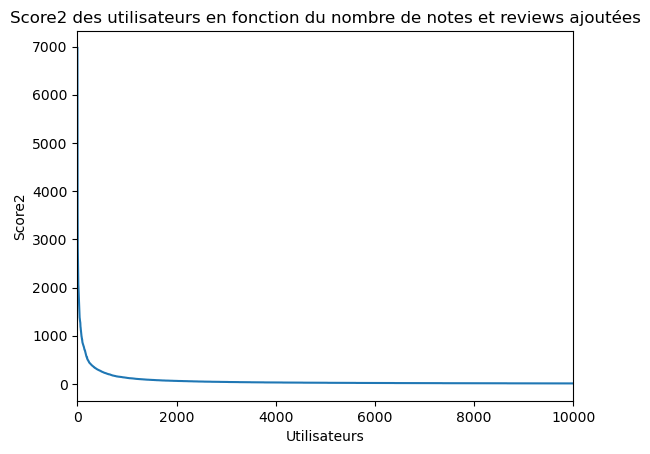

In [21]:
plt.plot(added_interactions['user_rating2'].tolist())
plt.xlim(0, 10000)
plt.xlabel('Utilisateurs')
plt.ylabel('Score2')
plt.title('Score2 des utilisateurs en fonction du nombre de notes et reviews ajoutées')

In [22]:
# Création d'un dataframe avec la valeur target qui représente la note globale de l'utilisateur qui détermine si il fait partie des super-users
overall_user_ratings = pd.DataFrame(columns = ['user_id', 'target'])

In [23]:
# Dans le dataframe overall_user_ratings, faire une jointure entre added_interactions et added_recipes au niveau de user_id
# On garde uniquement les colonnes user_id user_rating1 user_rating2 et target
overall_user_ratings = added_interactions.merge(added_recipes, on='user_id', how='left')
overall_user_ratings = overall_user_ratings[['user_id', 'user_rating1', 'user_rating2']]
overall_user_ratings['target'] = overall_user_ratings['user_rating1'] + overall_user_ratings['user_rating2']
overall_user_ratings = overall_user_ratings.sort_values('target', ascending=False)
print(overall_user_ratings.head())
print(overall_user_ratings.loc[overall_user_ratings['user_id'] == 424680])
print(overall_user_ratings.shape)

   user_id  user_rating1  user_rating2        target
5    89831   6971.048743   3047.050767  10018.099510
1    37449   3404.833269   5091.746331   8496.579600
0   424680   1084.450514   6971.048743   8055.499256
6    58104   2819.895026   2987.981784   5807.876810
3   169430   1535.281152   3704.079608   5239.360761
   user_id  user_rating1  user_rating2       target
0   424680   1084.450514   6971.048743  8055.499256
(226570, 4)


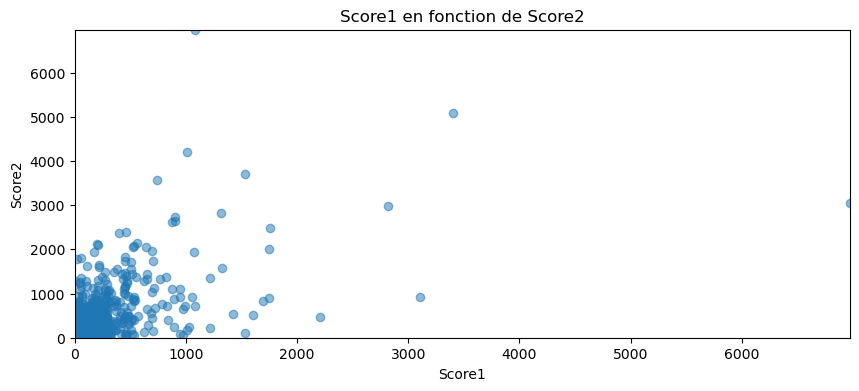

In [24]:
# Scatter plot de user_rating1 et user_rating2 pour voir la corrélation entre les deux scores
plt.figure(figsize=(10,4))
plt.xlim(0, overall_user_ratings['user_rating1'].max())
plt.ylim(0, overall_user_ratings['user_rating2'].max())
plt.xlabel('Score1')
plt.ylabel('Score2')
plt.title('Score1 en fonction de Score2')
plt.scatter(overall_user_ratings['user_rating1'], overall_user_ratings['user_rating2'], alpha=0.5)
plt.show()

In [25]:
# Coefficient de Pearson entre user_rating1 et user_rating2
print(f"Pearson coefficient between user_rating1 and user_rating2 is {overall_user_ratings['user_rating1'].corr(overall_user_ratings['user_rating2'])}")

Pearson coefficient between user_rating1 and user_rating2 is 0.6446952112011082


On peut donc dire qu'il y a une légère corrélation linéaire entre les deux variables. On peut donc estimer avec une certaine marge d'erreur qu'en général, les personnes qui obtiennent des notes élevées par rapport à leurs recettes ajoutées sont aussi les personnes qui laissent le plus de notes/reviews.

In [26]:
# Je rajoute le nombre de recettes ajoutées, le nombre de notes ajoutées et le nombre de notes et reviews ajoutées au dataframe overall_user_ratings
# Je vais ensuite regarder les corrélations des variables entre elles
overall_user_ratings = overall_user_ratings.merge(added_recipes, on='user_id', how='left')
overall_user_ratings = overall_user_ratings.merge(added_interactions, on='user_id', how='left')
overall_user_ratings = overall_user_ratings[['user_id', 'user_rating1_x', 'user_rating2_x', 'target', 'nb_recipes_added', 'rating_only', 'rating_and_review']]
overall_user_ratings = overall_user_ratings.rename(columns={'user_rating1_x': 'user_rating1', 'user_rating2_x': 'user_rating2'})
overall_user_ratings['user_rating1'] = overall_user_ratings['user_rating1'].fillna(0)
overall_user_ratings['user_rating2'] = overall_user_ratings['user_rating2'].fillna(0)
overall_user_ratings['nb_recipes_added'] = overall_user_ratings['nb_recipes_added'].fillna(0)

Text(0.5, 1.0, 'Nombre de notes et reviews ajoutées en fonction du nombre de recettes ajoutées')

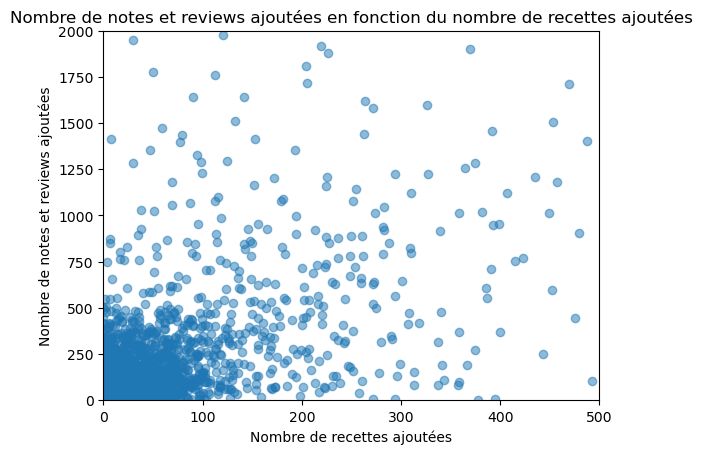

In [27]:
# On regarde la corrélation entre le nombre de recettes ajoutées et le nombre de notes et reviews ajoutées
plt.scatter(overall_user_ratings['nb_recipes_added'], overall_user_ratings['rating_and_review'], alpha=0.5)
plt.xlim(0,500)
plt.ylim(0,2000)
plt.xlabel('Nombre de recettes ajoutées')
plt.ylabel('Nombre de notes et reviews ajoutées')
plt.title('Nombre de notes et reviews ajoutées en fonction du nombre de recettes ajoutées')

In [28]:
# Matrice de corrélation entre les variables
corr = overall_user_ratings['nb_recipes_added'].corr(overall_user_ratings['rating_and_review'])
print(corr)

0.6931397248730387


Le coefficient de Pearson est environ de 0.68 donc on peut déduire qu'il y a une corrélation linéaire entre les deux variables plutôt prononcée.
Donc globalement, la relation étant positive, plus l'utilisateur aura ajouté de recettes et plus le nombre de ses notes et reviews laissées sera élevé.

On peut tenter de faire une regression linéaire pour prédire le nombre de notes/reviews laissées en fonction du nombre de recettes ajoutées par un utilisateur.

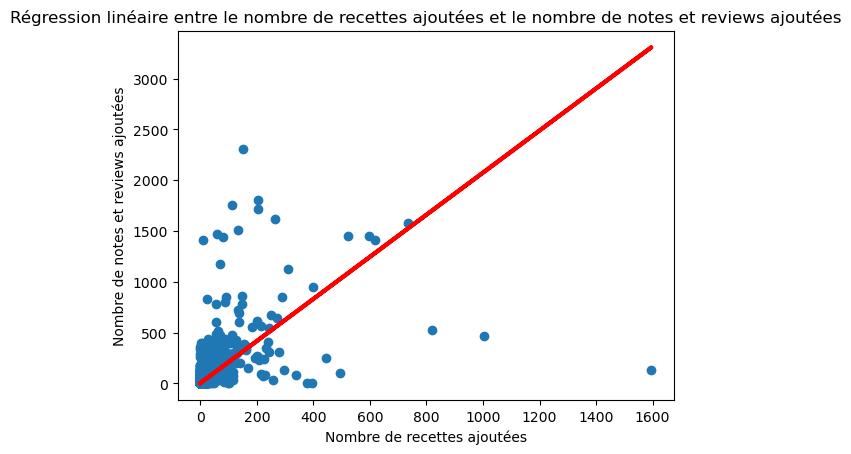

MSE : 1068.3001897806919
La pente : [[2.07084856]]
L'ordonnée à l'origine : [3.09054209]


In [29]:
# Régression linéaire entre le nombre de recettes ajoutées et le nombre de notes et reviews ajoutées
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = overall_user_ratings['nb_recipes_added'].values.reshape(-1,1)
y = overall_user_ratings['rating_and_review'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='red', linewidth=3)
plt.xlabel('Nombre de recettes ajoutées')
plt.ylabel('Nombre de notes et reviews ajoutées')
plt.title('Régression linéaire entre le nombre de recettes ajoutées et le nombre de notes et reviews ajoutées')
plt.show()
print(f"MSE : {mean_squared_error(y_test, y_pred)}")

# Coefficient de slope et d'intercept
print(f"La pente : {reg.coef_}")
print(f"L'ordonnée à l'origine : {reg.intercept_}")

Il aurait surement fallu faire un meilleur travail de nettoyage des données pour avoir des résultats plus pertinents comme enlever les valeurs trop proches de 0 (1 ou 2 recettes ajoutées/notes et reviews laissées).

Mais on peut considérer que la régression permet une prédiction plutôt correcte du nombre de notes/reviews laissées en fonction du nombre de recettes ajoutées par un utilisateur.

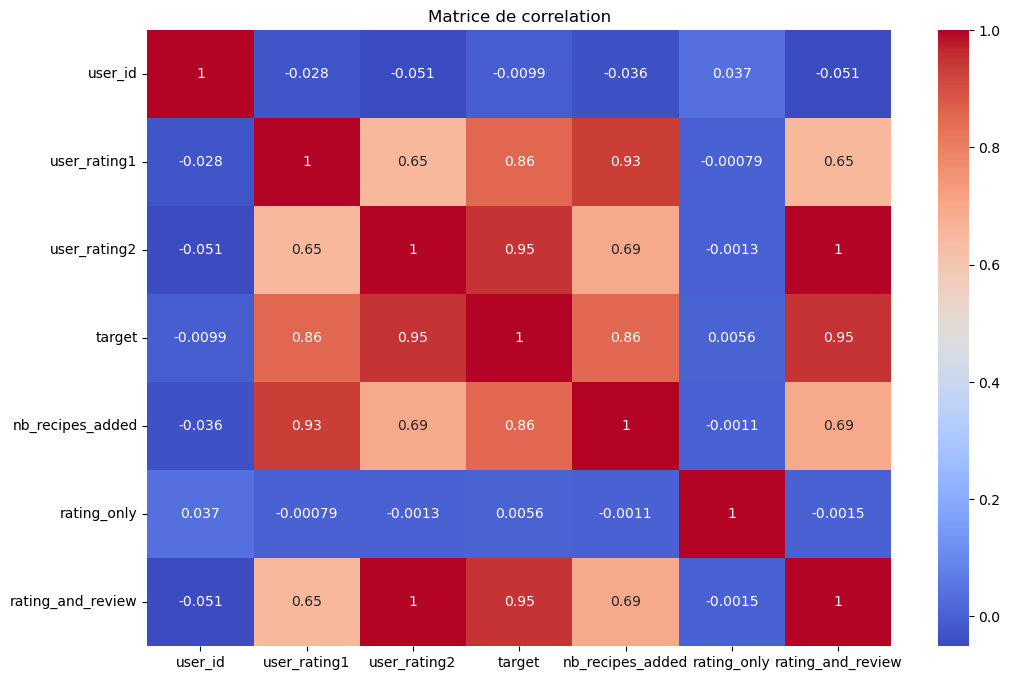

In [30]:
# Matrice de correlation entre les variables de overall_user_ratings
corr = overall_user_ratings.corr()

# Plot la matrice de correlation
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matrice de correlation')
plt.show()

Les coefficients supérieur à 0.9 étaient attendus et les coefficients de 0.69 est le coefficient que nous avons observé avant.

In [31]:
# Créer un dataframe avec les 5% des utilisateurs qui ont la plus grande valeur de target (les 5% premiers)
super_users = overall_user_ratings.head(int(overall_user_ratings.shape[0]*0.05))

a = super_users.shape[0]
b = overall_user_ratings.shape[0]
print("\nnombre de super-users: ", a)
print("nombre d'utilisateurs: ", b)
print("pourcentage de super-users: ", a/b*100)
print("\nDifférence entre la target min et max des super users :", super_users['target'].max()-super_users['target'].min())
print("Différence entre la meilleure et la pire target su tous les utilisateurs :", overall_user_ratings['target'].max()-overall_user_ratings['target'].min())



nombre de super-users:  11328
nombre d'utilisateurs:  226570
pourcentage de super-users:  4.999779317650174

Différence entre la target min et max des super users : 10012.963636959192
Différence entre la meilleure et la pire target su tous les utilisateurs : 10017.190756558395


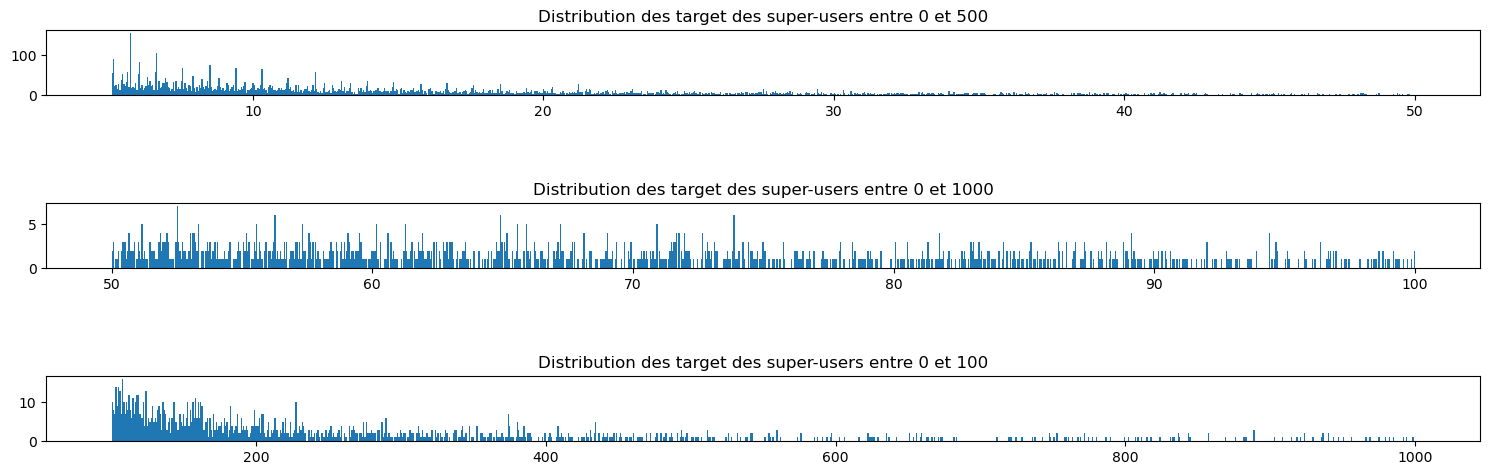

In [32]:
# Visualisation des target des super-users
fig, axs = plt.subplots(3, 1, figsize=(15, 3))
axs[0].hist(super_users['target'], bins=1000, range=(super_users['target'].min(), 50))
axs[0].set_title('Distribution des target des super-users entre 0 et 500')
axs[1].hist(super_users['target'], bins=1000, range=(50, 100))
axs[1].set_title('Distribution des target des super-users entre 0 et 1000')
axs[2].hist(super_users['target'], bins=1000, range=(100, 1000))
axs[2].set_title('Distribution des target des super-users entre 0 et 100')

# Espacer les subplots
plt.tight_layout()

# Grossir les subplots
plt.subplots_adjust(top=1.5)
plt.show()

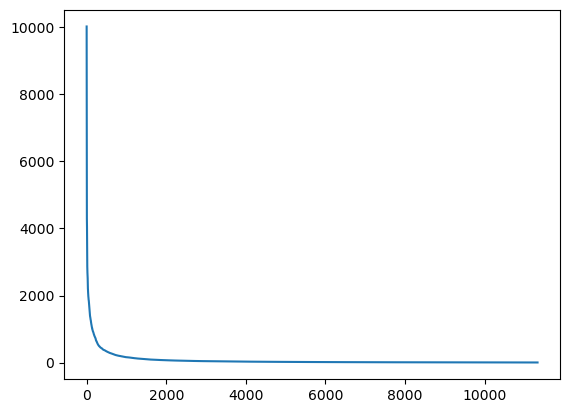

In [33]:
# On visualise la répartition des target des super-users
plt.plot(super_users['target'].tolist())

D'autres propositions possible pour déterminer le seuil de super-utilisateur : 
- Réduire leur nombre à 1% ou 2% des utilisateurs pour rendre le titre plus significatif
- Mettre un seuil fixe (>2000)
- Évaluer à partir de quand la target devient significativement grande et attribuer le rang de super-utilisateur à partir de ce seuil.
La différence entre la target du premier super utilisateur et du dernier est quasiment similaire à la différence à la différence entre la target du premier utilisateur et du dernier. Cela est du au fait que les (50) premiers super-utilisateurs ont une target beaucoup plus grande que tout le reste des utilisateurs.



Cepedant, dans notre première répartition, nous n'avons pas pis en compte le facteur de temporalité !!!
**le problème majeur est le suivant** :
- Un nouvel utilisateur qui veut devenir un super-utilisateur devra obligatoirement dépasser  les targets des super-utilsateurs actuels qui ont potentiellement stacké des points depuis *plusieurs années* mais qui sont probablement **inactifs** depuis un certain temps.

Dans une seconde partie, nous allons tenter d'intégrer le facteur d'activité des utilisateurs.

#### Nouvelle approche : Distribution des super-utilisateurs avec prise en compte des périodes d'activité

Pour intégrer la notion temporelle, on peut :
- Visualiser la distribution des activités globales (ajouts de recettes et notations/reviews) en fonction du temps (mois et années), puis comparer la période de l'activité moyenne des utilisateurs par rapport à l'activité moyenne globale. 

Si un utilisateur possède des peaks d'activité en dehors de la période moyenne globale, on peut insérer un coefficient mélioratif pour pondérer son user_rating.

- Lors de l'attribution des notes, prendre en compte la date de l'ajout et des notes/reviews et déterminer à partir de quand on considère que l'activité est récente ou non (2 ans ? 3 ans ? 5 ans ?) -> ajouter des variable sup_5ans, inf_5ans qui appliqueront des coefficients.

- Diviser le temps en plusieurs intervalles (0 à 1 mois, 1 mois à 3 mois, 3 mois à 1 an, 1 an à 2 ans, 2 ans à 3 ans) et attribuer à chaque intervalle un coefficient mélioratif qui va augmenter le score de l'utilisateur en fonction de si il a ajouté une recette plus ou moins récemment et/ou ajouté une note et review plus ou moins récemment.

On va privilégier la dernièr option.

Tous les nouveaux dataframes crées pour cette partie auront le suffixe **_temp**.

In [69]:
# On refait le même travail (céation des datafames puis jointure) en récupérant cette fois les colonnes "dates"
added_recipes_temp = pd.DataFrame(columns = ['user_id', 'recipe_id', 'user_rating1'])
added_recipes_temp['user_id'] = recipes['contributor_id']
added_recipes_temp['recipe_id'] = recipes['id']
added_recipes_temp['date'] = pd.to_datetime(recipes['submitted'])
added_recipes_temp = added_recipes_temp.merge(recipe_rating, on='recipe_id', how='left')
added_recipes_temp = added_recipes_temp[['user_id', 'recipe_id', 'date', 'user_rating1', 'weighted_recipe_rating', 'rating_count']]
added_recipes_temp.head(2)

,user_id,recipe_id,date,user_rating1,weighted_recipe_rating,rating_count
0,47892,137739,2005-09-16,NaN,0.098039,3
1,26278,31490,2002-06-17,NaN,0.090909,4


In [70]:
# Prendre la recette qui a été rajoutée le plus récemment pour choisir la date de référence
print(added_recipes_temp['date'].max())

2018-12-04 00:00:00


La dernière recette ajoutée date du **2018-12-04**. (Et le dernier avis/note laissés date du **2018-12-20**)

Je veux donc faire en sorte de déterminer les super-utilisateurs à la date la plus récente. On prend donc comme référence le **2018-12-21**.

In [71]:
# On définit la date de référence évoquée avant pour appliquer des coefficients de pondération aux notes des recettes en fonction de leur date d'ajout
ref_date = pd.to_datetime('2018-12-21')

# On crée des laps de temps pour définir les différents coefficients de pondération
one_month = timedelta(days=30)
three_months = timedelta(days=90)
six_months = timedelta(days=180)
one_year = timedelta(days=365)
two_years = timedelta(days=730)
three_years = timedelta(days=1095)
five_years = timedelta(days=1825)
ten_years = timedelta(days=3650)


In [72]:
# On pondère les notes des recettes en fonction de leur date d'ajout. Plus la recette est récente, plus la note est très conséquente
for i in range(len(added_recipes_temp['date'])):
    d = added_recipes_temp['date'][i]
    if ref_date - d  <= one_month:
        added_recipes_temp['user_rating1'][i] = added_recipes_temp['weighted_recipe_rating'][i] * 200000
    elif ref_date - d <= three_months and ref_date - d > one_month:
        added_recipes_temp['user_rating1'][i] = added_recipes_temp['weighted_recipe_rating'][i] * 100000
    elif ref_date - d <= six_months and ref_date - d > three_months:
        added_recipes_temp['user_rating1'][i] = added_recipes_temp['weighted_recipe_rating'][i] * 25000
    elif ref_date - d <= one_year and ref_date - d > six_months:
        added_recipes_temp['user_rating1'][i] = added_recipes_temp['weighted_recipe_rating'][i] * 5000
    elif ref_date - d <= two_years and ref_date - d > one_year:
        added_recipes_temp['user_rating1'][i] = added_recipes_temp['weighted_recipe_rating'][i] * 200
    elif ref_date - d > two_years:
        added_recipes_temp['user_rating1'][i] = added_recipes_temp['weighted_recipe_rating'][i] * 10

C:\Users\matsa\AppData\Local\Temp\ipykernel_29812\2343675220.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  added_recipes_temp['user_rating1'][i] = added_recipes_temp['weighted_recipe_rating'][i] * 10
C:\Users\matsa\AppData\Local\Temp\ipykernel_29812\2343675220.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  added_recipes_temp['user_rating1'][i] = added_recipes_temp['weighted_recipe_rating'][i] * 5000
C:\Users\matsa\AppData\Local\Temp\ipykernel_29812\2343675220.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

In [73]:
# Trier par nombre de votes obtenu décroissant
added_recipes_temp = added_recipes_temp.sort_values('rating_count', ascending=False)

In [79]:
# Nombre max de recettes ajoutées
print(f"Nombre max : {added_recipes_temp['rating_count'].max()} de recettes ajoutées\n")

# User_id de celui qui a ajouté le plus de recettes
a= added_recipes_temp.loc[added_recipes_temp['rating_count'] == added_recipes_temp['rating_count'].max()]['user_id'].values[0]
print(a, "est celui qui a ajouté le plus de recettes")

Nombre max : 1613 de recettes ajoutées

1762 est celui qui a ajouté le plus de recettes


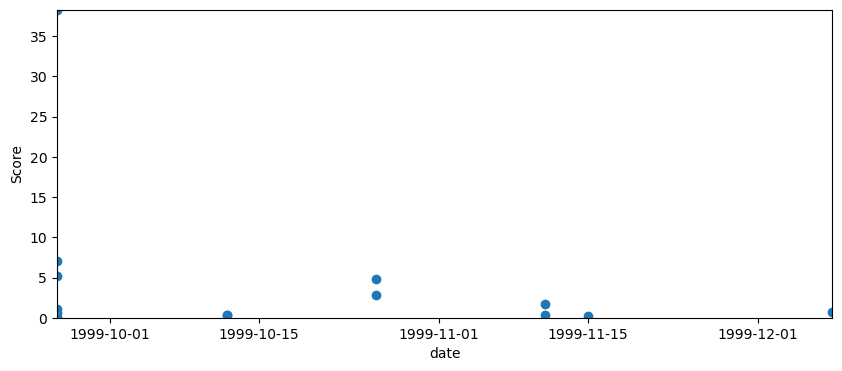

In [78]:
# On regade le scatterplot des ajouts de l'utilisateur qui a ajouté le plus de recette à partir de la question précédente
# On trie par date antérieurement
added_recipes_temp = added_recipes_temp.sort_values('date')
plt.figure(figsize=(10,4))
plt.ylim(0, added_recipes_temp.loc[added_recipes_temp['user_id'] == a]['user_rating1'].max())
plt.xlim(added_recipes_temp.loc[added_recipes_temp['user_id'] == a]['date'].min(), added_recipes_temp.loc[added_recipes_temp['user_id'] == a]['date'].max())
plt.xlabel('date')
plt.ylabel('Score')
plt.plot(added_recipes_temp.loc[added_recipes_temp['user_id'] == a]['date'], added_recipes_temp.loc[added_recipes_temp['user_id'] == a]['user_rating1'], 'o')

On peut se proposer aussi de réaliser : 
- un plot par année de toutes les recettes ajoutées poour voir si il y a des pics d'activité, ou des années où il y a eu plus d'activité que d'autres.
- un plot par année de toutes les notes/reviews laissées pour faire la même étude.

In [ ]:
# On groupe par user_id et calculer la somme de user_rating et le nombre de recettes ajoutées pour chaque utilisateur
added_recipes_temp = added_recipes_temp.groupby(['user_id']).agg({'user_rating1': 'sum', 'recipe_id': 'count'}).reset_index()

# On trie par recipe_id décroissant (le plus de recettes ajoutées)
added_recipes_temp = added_recipes_temp.rename(columns={'recipe_id': 'nb_recipes_added'})
added_recipes_temp = added_recipes_temp.sort_values('user_rating1', ascending=False)

In [ ]:
added_recipes_temp.head(2)

,user_id,user_rating1,nb_recipes_added
14349,400708,22280.620854,153
1837,33186,16683.850153,173


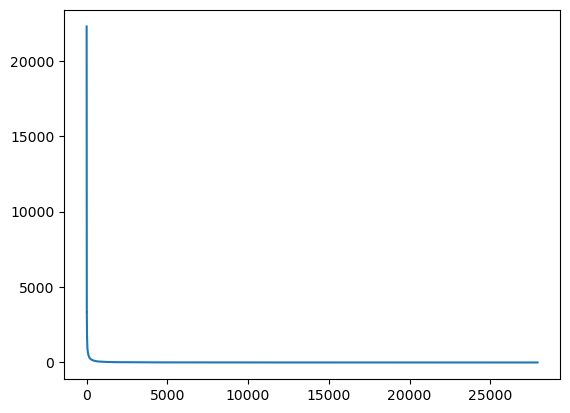

In [ ]:
# On regarde l'allure du score des utilisateurs en fonction du nombre de recettes ajoutées
plt.plot(added_recipes_temp['user_rating1'].tolist())

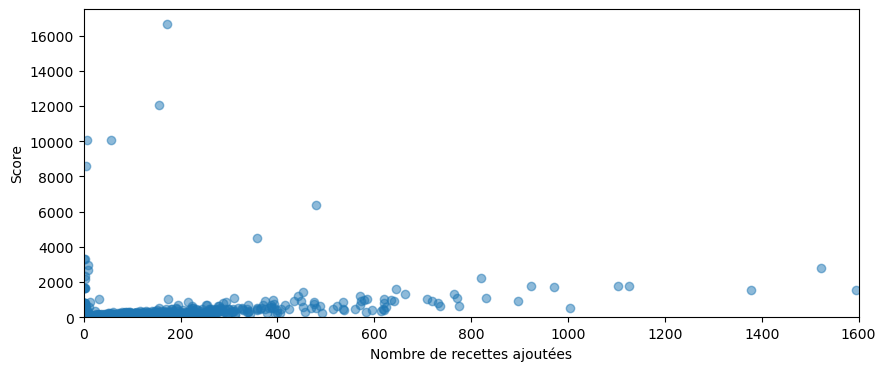

In [ ]:
# Plot le score des utilisateurs en fonction du nombre de recettes ajoutées pour comparer au résultat de la première méthode
plt.figure(figsize=(10,4))
plt.xlim(0, 1600)
plt.ylim(0, 17500)
plt.xlabel('Nombre de recettes ajoutées')
plt.ylabel('Score')
plt.scatter(added_recipes_temp['nb_recipes_added'], added_recipes_temp['user_rating1'], alpha=0.5)
plt.show()

On remarque que, comparé au premier graphique obtenu dans la première méthode, l'application de coefficient mélioratif a bien influé sur la répartition des scores en fonction du nombre de recettes ajoutées. Le score n'est pas forcément plus élevé à mesure que la quantité de recette ajoutées augmente.

La temporalité est donc prise en compte, peu d'ajouts récents ont plus de valeur que beaucoup d'ajouts anciens à partir d'un certain seuil.

In [ ]:
# Même chose que dans la première partie mais en ajoutant la colonne date
added_interactions_temp = pd.DataFrame(columns = ['user_id', 'recipe_id', 'rating_only', 'review_only', 'rating_and_review'])
added_interactions_temp['user_id'] = interactions['user_id']
added_interactions_temp['date'] = pd.to_datetime(interactions['date'])
added_interactions_temp['recipe_id'] = interactions['recipe_id']
added_interactions_temp['rating_only'] = interactions['rating'].notnull().astype(int)
added_interactions_temp['review_only'] = interactions['review'].notnull().astype(int)
added_interactions_temp['rating_and_review'] = (interactions['rating'].notnull() & interactions['review'].notnull()).astype(int)

# Si rating_and_review = 1, on met 0 dans rating et review de added_interactions
added_interactions_temp.loc[added_interactions_temp['rating_and_review'] == 1, 'rating_only'] = 0
added_interactions_temp.loc[added_interactions_temp['rating_and_review'] == 1, 'review_only'] = 0

In [ ]:
print(added_interactions_temp['date'].max())

2018-12-20 00:00:00


In [ ]:
# On suppose que le site bloque la possibilité de mettre seulement une review en obligeant à mettre au moins une note.
# On refait la pondération
for i in range(len(added_interactions_temp['date'])):
    d = added_interactions_temp['date'][i]
    if ref_date - d  <= one_month:
        added_interactions_temp['rating_and_review'][i] = added_interactions_temp['rating_and_review'][i] * 150000
        added_interactions_temp['rating_only'][i] = added_interactions_temp['rating_only'][i] * 100000
    elif ref_date - d <= three_months and ref_date - d > one_month:
        added_interactions_temp['rating_and_review'][i] = added_interactions_temp['rating_and_review'][i] * 20000
        added_interactions_temp['rating_only'][i] = added_interactions_temp['rating_only'][i] * 15000
    elif ref_date - d <= six_months and ref_date - d > three_months:
        added_interactions_temp['rating_and_review'][i] = added_interactions_temp['rating_and_review'][i] * 7000
        added_interactions_temp['rating_only'][i] = added_interactions_temp['rating_only'][i] * 4500
    elif ref_date - d <= one_year and ref_date - d > six_months:
        added_interactions_temp['rating_and_review'][i] = added_interactions_temp['rating_and_review'][i] * 1000
        added_interactions_temp['rating_only'][i] = added_interactions_temp['rating_only'][i] * 750
    elif ref_date - d <= two_years and ref_date - d > one_year:
        added_interactions_temp['rating_and_review'][i] = added_interactions_temp['rating_and_review'][i] * 50
        added_interactions_temp['rating_only'][i] = added_interactions_temp['rating_only'][i] * 30
    
added_interactions_temp = added_interactions_temp.rename(columns={'rating_only': 'score_rating_only', 'review_only': 'score_review_only', 'rating_and_review': 'score_rating_and_review'})


C:\Users\matsa\AppData\Local\Temp\ipykernel_29812\3541355219.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  added_interactions_temp['rating_and_review'][i] = added_interactions_temp['rating_and_review'][i] * 1000
C:\Users\matsa\AppData\Local\Temp\ipykernel_29812\3541355219.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  added_interactions_temp['rating_only'][i] = added_interactions_temp['rating_only'][i] * 750
C:\Users\matsa\AppData\Local\Temp\ipykernel_29812\3541355219.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

In [ ]:
# On regroupe par user_id
added_interactions_temp = added_interactions_temp.groupby(['user_id']).agg({'score_rating_only': 'sum', 'score_rating_and_review': 'sum', 'date' : 'count'}).reset_index()
added_interactions_temp = added_interactions_temp.rename(columns={'date': 'nb_of_interactions'})

# Trier par rating décroissant (le plus de notes ajoutées sans review)
added_interactions_temp = added_interactions_temp.sort_values('nb_of_interactions', ascending=False)
print(added_interactions_temp.head())

       user_id  score_rating_only  score_rating_and_review  nb_of_interactions
46329   424680                  0                     7671                7671
3826     37449                  0                     5603                5603
43248   383346                  0                     4628                4628
20019   169430                  0                   104904                4076
15168   128473                  0                   366566                3917


In [ ]:
# On calcule le user_rating2 pondéré
added_interactions_temp['user_rating2'] = added_interactions_temp['score_rating_only'] + added_interactions_temp['score_rating_and_review']

In [ ]:
# On pondère avec les resultats obtenus pour le user_rating1 afin que les poids soient égaux avec un coefficient
coefficient2 = added_recipes_temp['user_rating1'].max() / added_interactions_temp['user_rating2'].max()
added_interactions_temp['user_rating2'] = added_interactions_temp['user_rating2'] * coefficient2

print("Score2 max :", added_interactions_temp['user_rating2'].max())
print("Score2 min :", added_interactions_temp['user_rating2'].min())
print("Nombre de NaN :", added_interactions_temp['user_rating2'].isna().sum())
print("Score2 max :", added_interactions_temp['user_rating2'].loc[added_interactions_temp['user_rating2'] == added_interactions_temp['user_rating2'].min()].count())


Score2 max : 22280.62085353256
Score2 min : 0.013349011106410798
Nombre de NaN : 0
Score2 max : 132456


Text(0.5, 1.0, 'Score2 des utilisateurs en fonction du nombre de notes et reviews ajoutées')

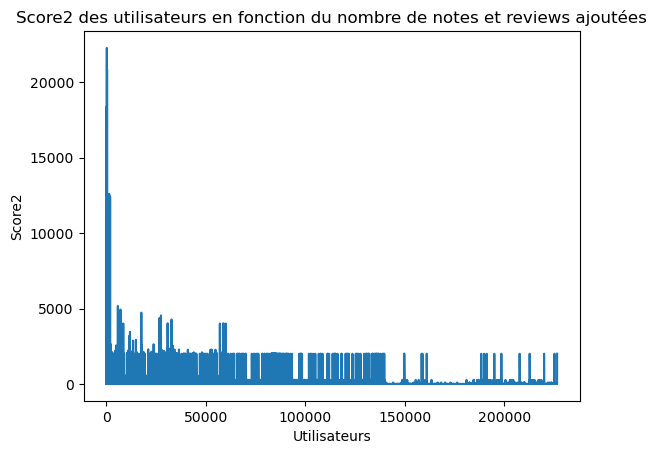

In [ ]:
# On plot le score des utilisateurs en fonction du nombre de notes et reviews ajoutées
plt.plot(added_interactions_temp['user_rating2'].tolist())
plt.xlabel('Utilisateurs')
plt.ylabel('Score2')
plt.title('Score2 des utilisateurs en fonction du nombre de notes et reviews ajoutées')

In [ ]:
# On crée le dataframe overall_user_rating_temp avec la valeur target qui représente la note globale de l'utilisateur qui détermine si il fait partie des super-users
overall_user_ratings_temp = added_interactions_temp.merge(added_recipes_temp, on='user_id', how='left')
overall_user_ratings_temp['user_rating1'] = overall_user_ratings_temp['user_rating1'].fillna(0)
overall_user_ratings_temp['user_rating2'] = overall_user_ratings_temp['user_rating2'].fillna(0)
overall_user_ratings_temp = overall_user_ratings_temp[['user_id', 'user_rating1', 'user_rating2']]
overall_user_ratings_temp['target'] = overall_user_ratings_temp['user_rating1'] + overall_user_ratings_temp['user_rating2']
overall_user_ratings_temp = overall_user_ratings_temp.sort_values('target', ascending=False)

In [ ]:
print(overall_user_ratings_temp.head())
print(overall_user_ratings_temp.shape)
print(overall_user_ratings_temp['target'].isnull().sum())

         user_id  user_rating1  user_rating2        target
55        400708  22280.620854  18390.358594  40670.979447
303      2123645      3.854714  22280.620854  22284.475567
440   2000498330      0.331126  20866.546758  20866.877884
155       198154      1.511885  17612.151293  17613.663178
1909       33186  16683.850153     41.622217  16725.472369
(226570, 4)
0


Text(0.5, 1.0, 'Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

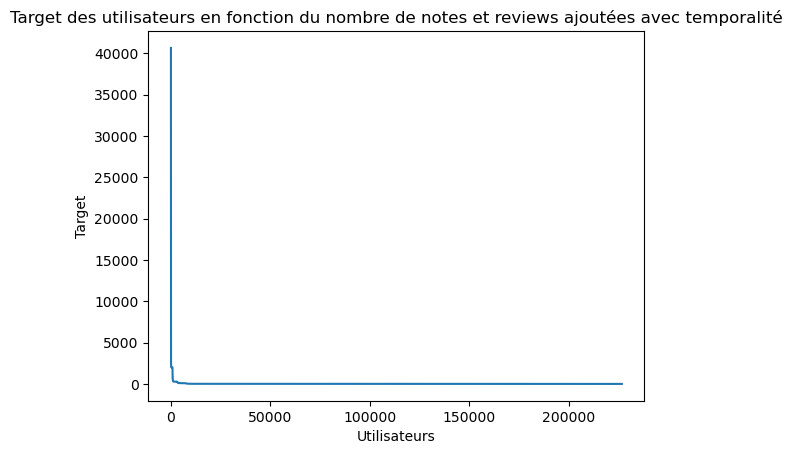

In [ ]:
# On plot les nouvelles targets pondérées issues de la deuxième méthode
plt.plot(overall_user_ratings_temp['target'].tolist())
plt.xlabel('Utilisateurs')
plt.ylabel('Target')
plt.title('Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

On obtient environ la même répartition des targets que pour la première méthode. On ne peut pas vraiment conclure sur la pertinence de la méthode avec prise en compte de la temporalité car les targets sont très disparates.

On aurait pu mieux visualiser en enlevant tous les utilisateurs qui ont des targets très négligeables (très proches de 0) car on peut considérer que ce sont des utilisateurs qui ont eu une action ponctuelle et il y a très longtemps (plus ou moins).
De cette manière, on peut représenter tous les utilisateurs qui participent 'vraiment' à la vie du site et qui mériteraient potentiellement le titre de super-utilisateur.

Text(0.5, 1.0, 'Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

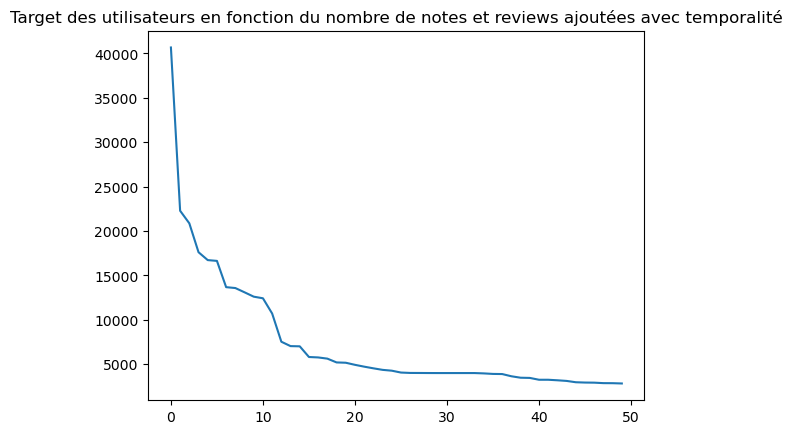

In [ ]:
# On regarde des portions de la distribution de la target 
plt.plot(overall_user_ratings_temp['target'].iloc[0:50].tolist())
plt.title('Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

Text(0.5, 1.0, 'Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

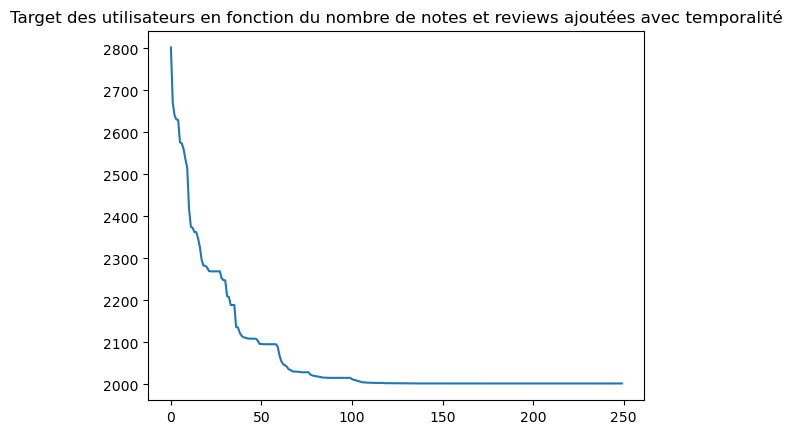

In [ ]:
plt.plot(overall_user_ratings_temp['target'].iloc[50:300].tolist())
plt.title('Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

Text(0.5, 1.0, 'Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

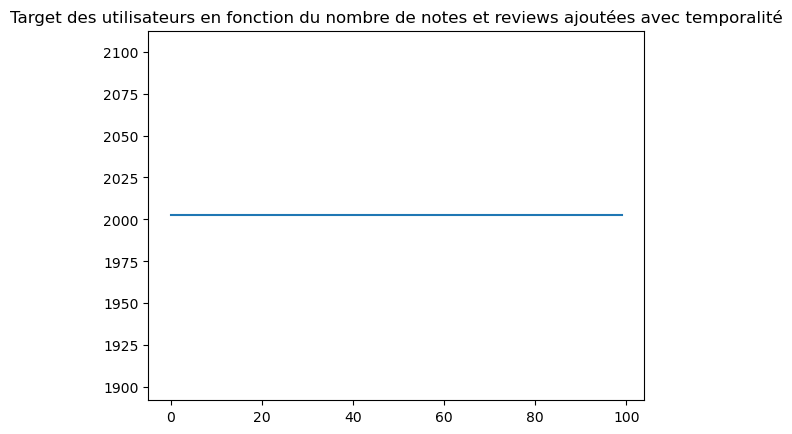

In [ ]:
plt.plot(overall_user_ratings_temp['target'].iloc[300:400].tolist())
plt.title('Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

Text(0.5, 1.0, 'Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

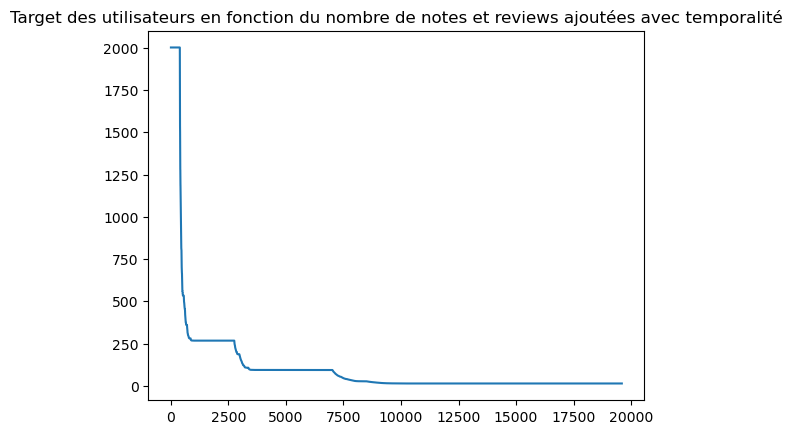

In [ ]:
plt.plot(overall_user_ratings_temp['target'].iloc[400:20000].tolist())
plt.title('Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

Text(0.5, 1.0, 'Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

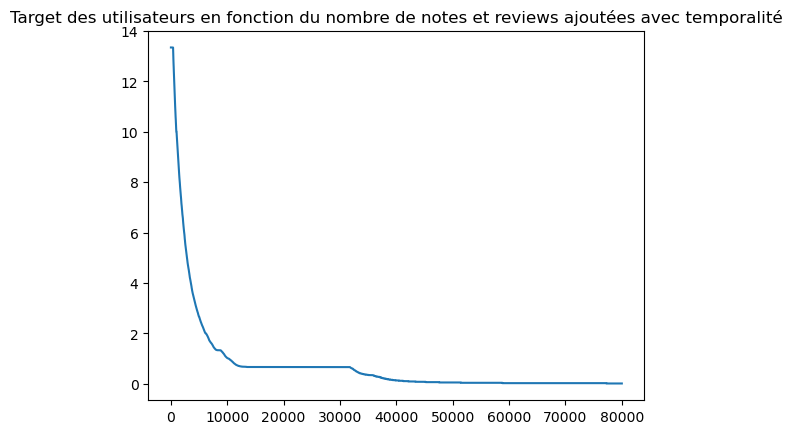

In [ ]:
plt.plot(overall_user_ratings_temp['target'].iloc[20000:100000].tolist())
plt.title('Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

On peut donc se dire que la target à partir de laquel on peut considérer qu'un utilisateur est actif est de 100.

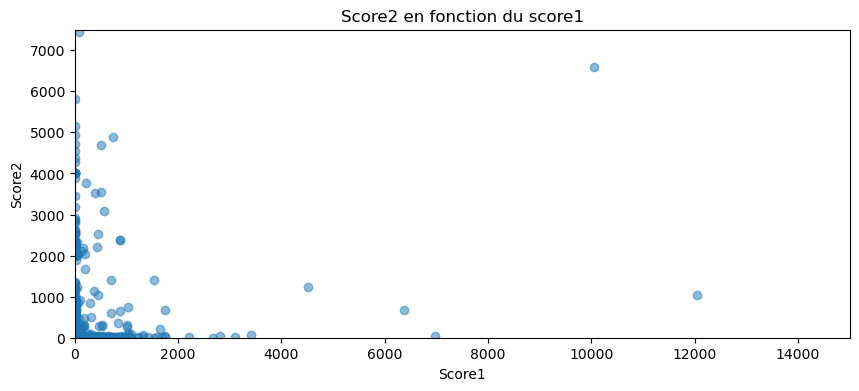

In [ ]:
# On regarde la relation entre user_rating1 et user_rating2
plt.figure(figsize=(10,4))
plt.xlim(0, 15000)
plt.ylim(0, 7500)
plt.xlabel('Score1')
plt.ylabel('Score2')
plt.title('Score2 en fonction du score1')
plt.scatter(overall_user_ratings_temp['user_rating1'], overall_user_ratings_temp['user_rating2'], alpha=0.5)
plt.show()

In [ ]:
# Correlation entre les variables de overall_user_ratings_temp
print(overall_user_ratings_temp['user_rating1'].corr(overall_user_ratings_temp['user_rating2']))

0.19396024442514742


In [ ]:
# Créer un dataframe avec les 5% des utilisateurs qui ont la plus grande valeur de target
super_users_temp = overall_user_ratings_temp.head(int(overall_user_ratings_temp.shape[0]*0.05))
print(super_users_temp.head())
print(super_users_temp.shape)

a = super_users_temp.shape[0]
b = overall_user_ratings_temp.shape[0]
print("\nnombre de super-users: ", a)
print("nombre d'utilisateurs: ", b)
print("pourcentage de super-users: ", a/b*100)

         user_id  user_rating1  user_rating2        target
55        400708  22280.620854  18390.358594  40670.979447
303      2123645      3.854714  22280.620854  22284.475567
440   2000498330      0.331126  20866.546758  20866.877884
155       198154      1.511885  17612.151293  17613.663178
1909       33186  16683.850153     41.622217  16725.472369
(11328, 4)

nombre de super-users:  11328
nombre d'utilisateurs:  226570
pourcentage de super-users:  4.999779317650174


In [ ]:
# On enlève les utilisateurs qui ont moins de 100 de target
new_overall_user_ratings_temp = overall_user_ratings_temp.loc[overall_user_ratings_temp['target'] >= 100]
print(new_overall_user_ratings_temp.shape)

(3788, 4)


Text(0.5, 1.0, 'Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

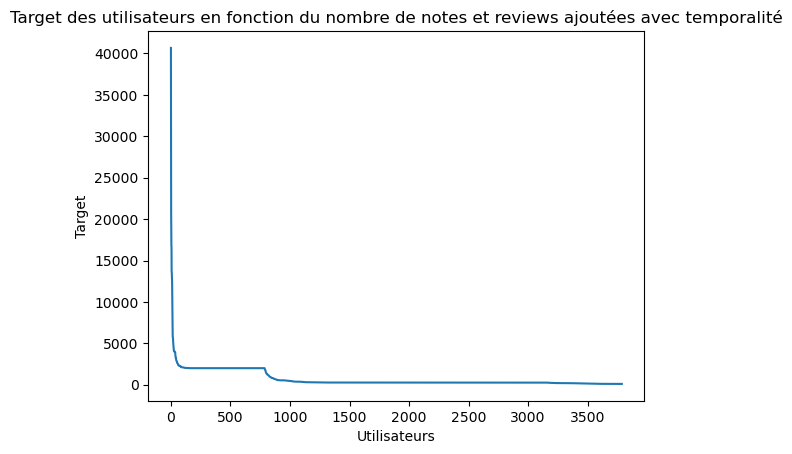

In [ ]:
# On plot la nouvelle distribution des targets
plt.plot(new_overall_user_ratings_temp['target'].tolist())
plt.xlabel('Utilisateurs')
plt.ylabel('Target')
plt.title('Target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

In [ ]:
# On définit les nouveaux super-users (beaucoup moins nombreux)
new_super_users_temp = new_overall_user_ratings_temp.head(int(new_overall_user_ratings_temp.shape[0]*0.05))
print(new_super_users_temp.shape)

(189, 4)


Text(0.5, 1.0, 'Nouvelle target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

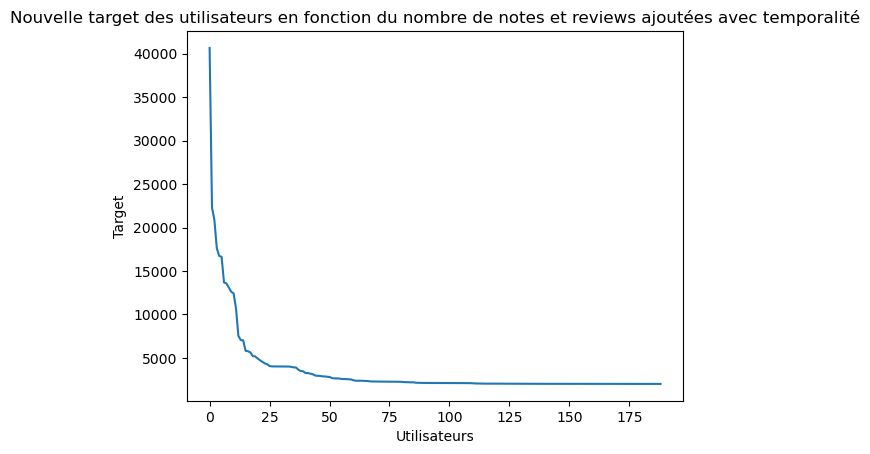

In [ ]:
# On plot la nouvelle distribution des targets
plt.plot(new_super_users_temp['target'].tolist())
plt.xlabel('Utilisateurs')
plt.ylabel('Target')
plt.title('Nouvelle target des utilisateurs en fonction du nombre de notes et reviews ajoutées avec temporalité')

On obtient finalement une "meilleure" répartition des targets, sachant que si un utilisateur souhaite devenir super-utilisateur, il lui suffira de dépasser la taget de 100 et prendre la place du dernier super-utilisateur (ou venir augmenter le nombre maximum d'utilisateurs).

Cepedant on remarque qu'il y a finalement très peu de super-utilisaeturs par rapport au nombre d'utilisateurs qui ont eu au moins une activité sur le site (189 sur 226570 au total = 0.08% des utilisateurs). Cela n'est pas forcément une mauvaise chose, le titre de super-utilisateur n'étant pas un titre dur à obtenir au vu de la pondération.

Cela a constitué une première approche, mais il existe de nombreuses pistes d'amélioration et de nouvelles approches au problème.

Les améliorations possibles sont les suivantes :
- Ajouter une auto-régulation du nombre de super-utilisateurs plutôt que d'augmenter de manière indéfinie le nombre global de super-utilisateurs. Pour cela, il faudrait réaliser un ajustement du score target de maniere periodique pour mettre à jour la liste des super utilisateurs. Cela passerait par la révision de la période à partir de laquelle une action de l'utilisateur sur le site n'a plus de poids effectif dans la target (1an).

- Une autre amélioration aurait été de pondérée de manière flexible en fonction des tendances et saisonnalités des activités des utilisateurs sur leur site.

- Une autre amélioration serait l'intégration de "streak" (séries) d'activité. Plus un utilisateur est actif sur une période courte, plus il gagne des bonus sur le score qui lui est attribué. Cela permettrait de récompenser les utilisateurs qui sont actifs sur une période courte mais intense tout en faisant fonctionner le site de manière plus régulière.


Par ailleurs, une autre approche au problème serait de modifier complètement le calcul de la target et intégrer une toute nouvelle fonction score. On peut par exemple récupérer le scatter plot du nombre de recettes ajoutées en fonction du nombre de notes/review laissées, puis tracer un arc de cercle (ou autre forme géométrique elliptique) pour déterminer le seuil à partir duqyel un user "a le droit de devenir un utilisateur. La distribution que nous avons pu observer permettait bien d'effectuer cela. Ensuite, on prendrait en compte de la même manière la temporalité des actions de l'utilisateur pour pondérer son score, au même tire que les streaks et les ajustements périodiques de la target.

In [ ]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Overall execution time : {execution_time//60} minutes and {round(execution_time%60)} seconds")

Overall execution time : 4.0 minutes and 21 seconds
